In [395]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [396]:
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [541]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('/content/gdrive/My Drive/project/50000.csv',encoding='ISO-8859-1')
# data['tags'] = data['tags'].apply(literal_eval)
# x = data.nutrition
x = data.drop(["name","id","contributor_id","nutrition","submitted","steps","tags","description","ingredients"],axis = 1)
y = data['5-ingredients-or-less']


In [542]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convert each category in the label to an integer
# le = LabelEncoder()
# y= le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=1/5,random_state=0)

In [543]:
print(y)
print(y.shape)

0        1
1        0
2        0
3        1
4        1
        ..
49995    1
49996    1
49997    0
49998    1
49999    1
Name: 5-ingredients-or-less, Length: 50000, dtype: int64
(50000,)


In [544]:
print(y_train)

20330    0
17532    1
45819    1
34807    1
31888    1
        ..
21243    0
45891    1
42613    1
43567    1
2732     0
Name: 5-ingredients-or-less, Length: 40000, dtype: int64


In [545]:
print(X_train)

       minutes  healthy  ...  stated_fat  total_carbonhydrate
20330       70        0  ...          29                    6
17532       60        1  ...           6                   13
45819       50        0  ...           0                    5
34807      130        1  ...           0                    5
31888       25        0  ...          12                    3
...        ...      ...  ...         ...                  ...
21243       10        1  ...          29                    9
45891       10        0  ...           0                    1
42613       20        0  ...           0                    0
43567        1        0  ...           0                    1
2732        20        0  ...          58                   18

[40000 rows x 19 columns]


 **K-NN**

In [547]:
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1,21): # Declare an of the KNN classifier class with the value with neighbors.

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train) # Fit the model with training data and target values
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [548]:
## score that comes from testing on the same datapoints that were used for training
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


In [549]:
## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 69.46 % and k = [19]


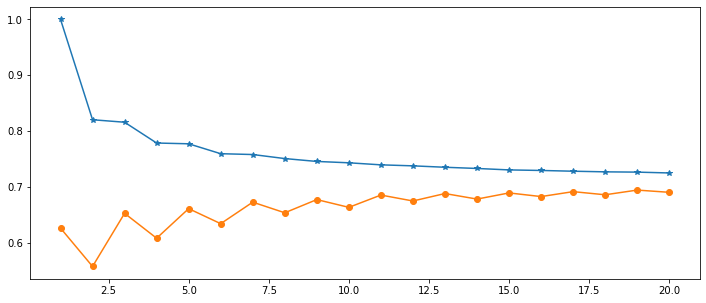

In [550]:
plt.figure(figsize=(12,5))
plt.plot(range(1,21),train_scores,marker='*',label='Train Score')
plt.plot(range(1,21),test_scores,marker='o',label='Test Score')

In [551]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(19)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.6946

In [552]:
#import confusion_matrix
from sklearn.metrics import confusion_matrix
#let us get the predictions using the classifier we had fit above
y_pred = knn.predict(X_test)
#confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,340,2613,2953
1,441,6606,7047
All,781,9219,10000


In [553]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.44      0.12      0.18      2953
           1       0.72      0.94      0.81      7047

    accuracy                           0.69     10000
   macro avg       0.58      0.53      0.50     10000
weighted avg       0.63      0.69      0.63     10000



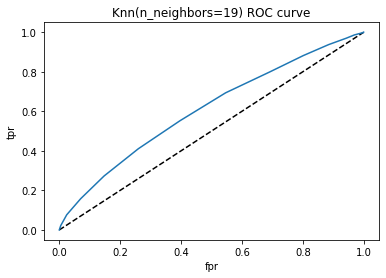

In [554]:
from sklearn.metrics import roc_curve
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=19) ROC curve')
plt.show()

In [555]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.6088752885600821

In [556]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,25)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.7019
Best Parameters: {'n_neighbors': 23}


**NAIVE** **BAYES**

In [557]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix


In [558]:
# Initiating the Gaussian Classifier
mod = GaussianNB()

# Training your model 
mod.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [559]:
# Predicting Outcome 
predicted = mod.predict(X_test)

In [560]:
mod.score(X_test,y_test)

0.9983

In [561]:
# Confusion Matrix
y_pred = mod.predict(X_test)
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[2945    8]
 [   9 7038]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2953
           1       1.00      1.00      1.00      7047

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



**NN**

In [565]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier 
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [566]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1000,verbose=2)  
mlp.fit(X_train, y_train)  

Iteration 1, loss = 0.47725949
Iteration 2, loss = 0.08979944
Iteration 3, loss = 0.01498786
Iteration 4, loss = 0.00457617
Iteration 5, loss = 0.00345021
Iteration 6, loss = 0.00124280
Iteration 7, loss = 0.00081198
Iteration 8, loss = 0.00057198
Iteration 9, loss = 0.00041606
Iteration 10, loss = 0.00031749
Iteration 11, loss = 0.00024884
Iteration 12, loss = 0.00019950
Iteration 13, loss = 0.00016206
Iteration 14, loss = 0.00012727
Iteration 15, loss = 0.00010435
Iteration 16, loss = 0.00008838
Iteration 17, loss = 0.00007581
Iteration 18, loss = 0.00006597
Iteration 19, loss = 0.00005779
Iteration 20, loss = 0.00005119
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=2, warm_start=False)

In [567]:
predictions = mlp.predict(X_test)

from sklearn import metrics 
print("Accuracy", metrics.accuracy_score(y_test, predictions))
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  

Accuracy 1.0
[[2953    0]
 [   0 7047]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2953
           1       1.00      1.00      1.00      7047

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [568]:
print("Accuracy on training set: {:.3f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 1.000


In [569]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
import pandas as pd
import numpy as np

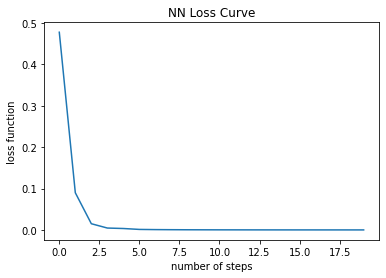

In [571]:
plt.plot(mlp.loss_curve_)
plt.title("NN Loss Curve")
plt.xlabel("number of steps")
plt.ylabel("loss function")
plt.show()

In [572]:
(mlp.intercepts_[0]).shape

(10,)

In [573]:
(mlp.coefs_[0]).shape

(19, 10)

In [574]:
mlp.intercepts_[0]

array([-0.38156207, -0.0706702 ,  0.48001347,  0.32276311,  0.69152722,
        0.63241397,  0.20200781,  0.41858214,  0.18358494,  0.99775849])

In [575]:
mlp.coefs_[0]

array([[-0.16685621,  0.19598705,  0.15398386,  0.21815799, -0.54442151,
        -0.3622947 , -0.13860211, -0.32921521, -0.05451202,  0.22524533],
       [ 0.01642013, -0.31243389, -0.59625939,  0.09285406, -0.08739797,
         0.27482552, -0.26908558,  0.32244785,  0.43672296,  0.21059056],
       [ 0.21636344, -0.22974621, -0.57161612,  0.38768195, -0.08830424,
        -0.50365911, -0.33571557, -0.07885524,  0.37628775, -0.05980102],
       [ 0.29009455, -0.4458314 , -0.48291606,  0.22749563, -0.03405231,
        -0.35541467, -0.59522334,  0.05625769,  0.32132016,  0.11813832],
       [ 0.08463263, -0.09508971,  0.28113632,  0.1023112 ,  0.07639749,
        -0.71101226, -0.04563642,  0.0363393 ,  0.27923496,  0.11170293],
       [-0.09204754, -0.32496791, -0.55383963,  0.11825693, -0.0310577 ,
        -0.25839873, -0.34076967, -0.11201367,  0.09160851, -0.25284057],
       [ 0.06559047, -0.28531412, -0.11627816,  0.26504565, -0.07148655,
        -0.00983686, -0.25052862,  0.0878655 

In [576]:
#Adjust the number of hidde Layer/ hidden node to improve the NN performance. Write your code below.

mlp = MLPClassifier(hidden_layer_sizes=(5,5), max_iter=1000,verbose=2)  
mlp.fit(X_train, y_train) 

predictions = mlp.predict(X_test)  

Iteration 1, loss = 0.56564285
Iteration 2, loss = 0.34470031
Iteration 3, loss = 0.20807419
Iteration 4, loss = 0.15816823
Iteration 5, loss = 0.13060766
Iteration 6, loss = 0.11093934
Iteration 7, loss = 0.09557844
Iteration 8, loss = 0.08314843
Iteration 9, loss = 0.07282381
Iteration 10, loss = 0.06387994
Iteration 11, loss = 0.02696776
Iteration 12, loss = 0.00430306
Iteration 13, loss = 0.00186380
Iteration 14, loss = 0.00107922
Iteration 15, loss = 0.00068958
Iteration 16, loss = 0.00048934
Iteration 17, loss = 0.00035217
Iteration 18, loss = 0.00026718
Iteration 19, loss = 0.00020714
Iteration 20, loss = 0.00016560
Iteration 21, loss = 0.00013326
Iteration 22, loss = 0.00010803
Iteration 23, loss = 0.00008871
Iteration 24, loss = 0.00007347
Iteration 25, loss = 0.00006153
Iteration 26, loss = 0.00005264
Iteration 27, loss = 0.00004496
Iteration 28, loss = 0.00003821
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [577]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
print("Accuracy", metrics.accuracy_score(y_test, predictions))
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))

Accuracy 1.0
[[2953    0]
 [   0 7047]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2953
           1       1.00      1.00      1.00      7047

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



**Logistic** **Regression**

In [579]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=0.01, max_iter=10000).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 1.000
Test set score: 1.000


In [580]:
logreg.intercept_.T

array([2.43225111])

In [581]:
logreg.coef_.T

array([[-7.71119278e-04],
       [ 3.24216856e-03],
       [ 1.32693046e-03],
       [-3.63929514e-03],
       [ 2.27674770e-02],
       [ 1.60419524e-02],
       [ 1.57993234e-02],
       [ 5.15203371e-01],
       [ 3.70101599e+00],
       [-4.26695904e-02],
       [-4.88271497e-02],
       [-8.60067651e-01],
       [ 4.10888537e-03],
       [-7.10899801e-03],
       [ 1.36328796e-02],
       [-7.84046241e-03],
       [-8.48092350e-03],
       [ 1.24786016e-02],
       [ 5.83678093e-03]])

In [582]:
print(y_test)

11841    1
19602    1
45519    1
25747    1
42642    0
        ..
25091    0
27853    0
47278    1
37020    1
2217     1
Name: 5-ingredients-or-less, Length: 10000, dtype: int64


In [583]:
from sklearn.metrics import classification_report, confusion_matrix  
y_pred = logreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))
##before processing data in PCA, we got 0.73 accurancy, from this we can observe the accurancy do not decrease a lot
#we can also normally use the model, and largely reduce caculation by using PCA

[[2953    0]
 [   0 7047]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2953
           1       1.00      1.00      1.00      7047

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [584]:
#!conda install -c conda-forge scikit-plot
import matplotlib.pyplot as plt
import scikitplot as skplt
y_pred_probas = logreg.predict_proba(X_test)

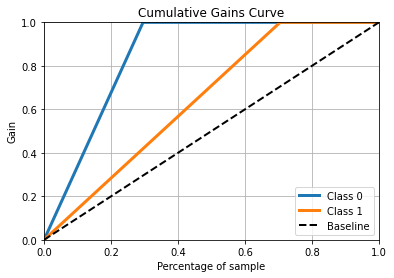

In [585]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_probas)
plt.show()

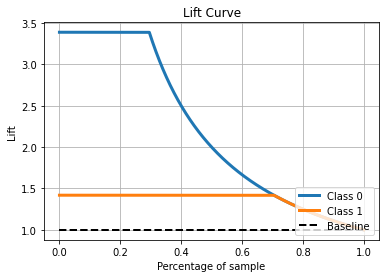

In [586]:
skplt.metrics.plot_lift_curve(y_test, y_pred_probas)
plt.show()